In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
# Import data and create df

data = pd.read_csv("/Users/Stacy/Documents/WebDevelopment/projects/sexualAssault_datasets/2010-2018_sexcrimes_violentcrimes.csv", index_col="CAD Event Number")
data = pd.DataFrame(data)

In [4]:
# Rename columns to be pythonic

data.columns = ['event_clearing', 'call_type', 'priority', 
                'initial_call_type', 'final_call_type', 'original_time_queued',
               'arrived_time', 'precinct', 'sector', 'beat']

In [5]:
# ID all calls cancelled by dispatch
cancelled_calls = data[data.event_clearing.str.contains("CANCELLED")]

# Delete rows with cxl'd calls

data = data[data.event_clearing != 'RESPONDING UNIT(S) CANCELLED BY RADIO']
data = data[data.event_clearing != 'DUPLICATED OR CANCELLED BY RADIO']

#### Clean time values

In [6]:
# Change original_time_queued to datetime
data['original_time_queued'] = pd.to_datetime(data.original_time_queued)

# Change arrived_time to datetime
data['arrived_time'] = pd.to_datetime(data.arrived_time, format='%b %d %Y %I:%M:%S:%f%p')

# Add time delta between original_time_queued and arrived_time
data['time_delta'] = ((data.arrived_time - data.original_time_queued)/np.timedelta64(1, 's')).astype(int)

In [7]:
# Add columns for arrived year and month

data['year'] = data.arrived_time.dt.year
data['month'] = data.arrived_time.dt.month

# For rows with bad arrived time: change month and year to original_time_queued
# Where arrive_time year = 1900, change data.year and data.month to original_time_queued year

mask = data.year < 1901
column_name_year = 'year'
column_name_month = 'month'
data.loc[mask, column_name_year] = data.original_time_queued.dt.year
data.loc[mask, column_name_month] = data.original_time_queued.dt.month

#### Define terms

In [8]:
# Define TRU initial call types
TRU_call_types = [
    'TRU - ASLT - WITH OR W/O WPNS (NO SHOOTINGS)',
    'TRU - RAPE',
    'TRU - LEWD CONDUCT',
    'TRU - CHILD ABUSED, NEGLECTED',
    'TRU - THREATS',
    'TRU - ROBBERY',
    'TRU - ASLT - MOLESTED ADULT (GROPED, FONDLED, ETC)',
    'TRU - HARASSMENT',
    'TRU - SEX IN PUBLIC',
    'TRU - THEFT',
    'TRU - FOLLOW UP',
    'TRU - MVC - HIT AND RUN',
    'TRU - LURING',
    'TRU - FORGERY/CHKS/BUNCO/SCAMS/ID THEFT',
    'TRU - SUSPICIOUS CIRCUMSTANCES']

In [9]:
# Define terms that ID which crime_type

# Define terms that ID rape CFS
rape_terms = 'STRANGER|ACQUAINTANCE'
rape_call_types = [
    '--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    '--RAPE - UNKNOWN SUSPECT (STRANGER)']

# Define terms that ID sex crimes
sex_crime_terms = 'CSEC|LEWD|MOLESTING|STRANGER|ACQUAINTANCE'
sex_crime_call_types = [
    '--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT',
    '--RAPE - KNOWN SUSPECT (ACQUAINTANCE)',
    '--RAPE - UNKNOWN SUSPECT (STRANGER)',
    '--SEX OFFENSES (RAPE) - MOLESTING',
    '--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC)']

# Define terms that ID other violent crimes
violent_crime_terms = 'KIDNAP|HOMICIDE|SHOOTING|ASSAULTS|ROBBERY'
violent_crime_call_types = [
    '--ASSAULTS - FIREARM INVOLVED',
    '--ROBBERY - ARMED',
    '--HOMICIDE',
    '--KIDNAP - GENERAL',
    '--DRIVE BY SHOOTING - NO INJURIES']

In [10]:
# ID clearing codes for is_arrest

arrest_cc = ['PHYSICAL ARREST MADE']

### Add columns for is_arrest, is_TRU, and crime_type

In [11]:
# Add column identifying if there was an arrest
data['is_arrest'] = np.where(data['event_clearing'].isin(arrest_cc), 'yes', 'no')

# Add column identifying if this was A TRU call
data['is_TRU'] = np.where(data['initial_call_type'].isin(TRU_call_types), 'yes', 'no')

# Add column identifying crime type
data['crime_type'] = np.where(data['final_call_type'].isin(sex_crime_call_types), 'sex crime', 'violent crime')

## 1. 2018 Sees increase in reports of sex crimes



2017 saw an increase in calls reporting sex crimes, whereas other violent crimes in the city continued a downward trend that began in 2015.

Reports of non-rape sex crime increased each year of this analysis except for 2012. Between 2010 and 2018 the number of calls reporting non-rape sex crimes has nearly doubled in Seattle.

In this same time period, Seattle saw a decrease in the reporting of non-sex-related violent crimes.

In [83]:
# Add crime_type for each call type as a violent crime, sex crime, or rape
is_rape = data['final_call_type'].str.contains(rape_terms)
is_vc = data['final_call_type'].str.contains(violent_crime_terms)
is_sex_crime = data['final_call_type'].str.contains(sex_crime_terms)
is_lewd_conduct = data['final_call_type'].str.contains("LEWD")
is_arrest_mask = data['is_arrest'] == "yes"
is_tru_mask = data['is_TRU'] == "yes"

data['crime_type'] = np.where(data['final_call_type'].isin(rape_call_types), 'rape',
                                (np.where(data['final_call_type'].isin(sex_crime_call_types),
                                          'other sex crime', 'violent crime')))

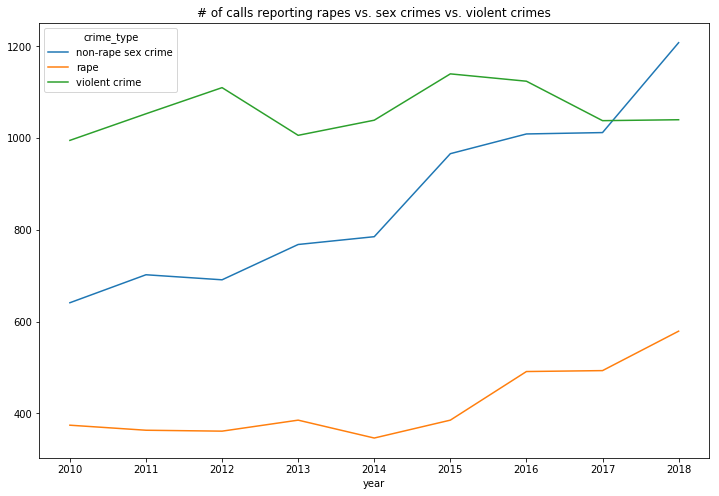

In [13]:
# Compare number of rape calls, non-rape sex crime calls, and violent crime calls by year

data.groupby('crime_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(12,8),
    title="# of calls reporting rapes vs. sex crimes vs. violent crimes")



Between 2010 and 2018 there has been a general increase in the number of calls each year for lewd conduct. During this time period, number of lewd conduct calls in the North, East and West precincts have steadily increased. In the same time period, these calls in the South and Southwest precincts have remained mostly flat. 

In 2015 and 2018 there were marked increases in these calls in the North, East and West precincts.

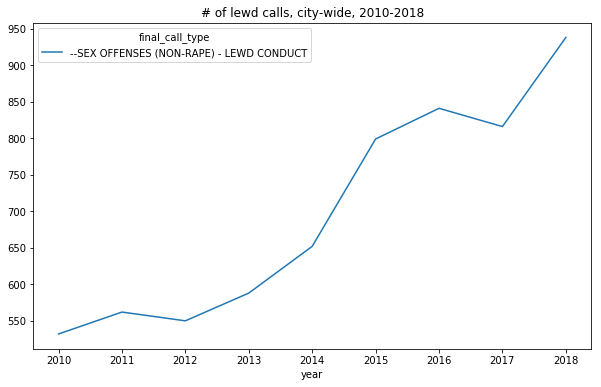

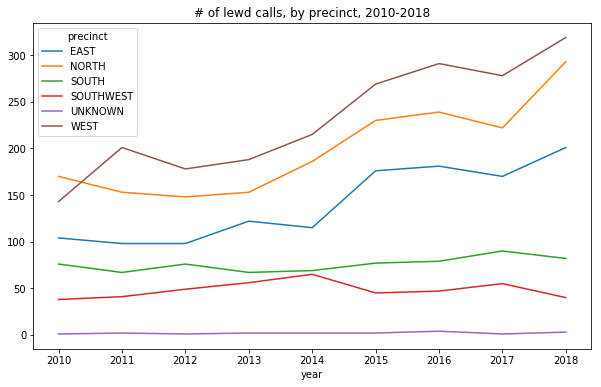

In [14]:
# Plot lewd conduct calls, by precinct, over the years
lewd_df = data[is_lewd_conduct]

lewd_df.groupby('final_call_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of lewd calls, city-wide, 2010-2018")

lewd_df.groupby('precinct').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of lewd calls, by precinct, 2010-2018")


In [110]:
# data.head()

## 2. Arrests for VC have increased

In 2018, the percentage rape calls that resulted in an arrests was 5.7%. That same year, the rate of arrest for violent crimes was nearly one and a half times higher at 13.8%. At the same time, Seattle saw reports of violent crimes drop for the third year in a row, while calls reporting rapes are at an all-time high. Since the #MeToo movement started towards the end of 2017, more victims have been coming forward to report sexual assaults. And, even though rapes are notoriously underreported, this increase in rape calls doesn't necessarily indicate and overall increase in these crimes.

Even though the number of arrests for non-sex-related violent crime was flat from 2017 to 2018, the rate of arrests (percentage) has increased because there's been a drop in reports of these crimes. Conversely, reports of rape have steadily increased since 2014. Understandibly, the number of calls that have resulted in arrest have also increased but the rate of arrests have not kept pace. Between 2015 and 2017 there was a dramatic decrease in arrest rates related to rape calls - dropping from a 7% arrest rate in 2015 to 3.4% in 2017. Last year, the arrest rate rebounded to 5.7%, but was still much lower than the high of 10.2% in 2012. And, given that last year's violent crime arrest rate of 13.75%, arrests rates for rape calls still lags.

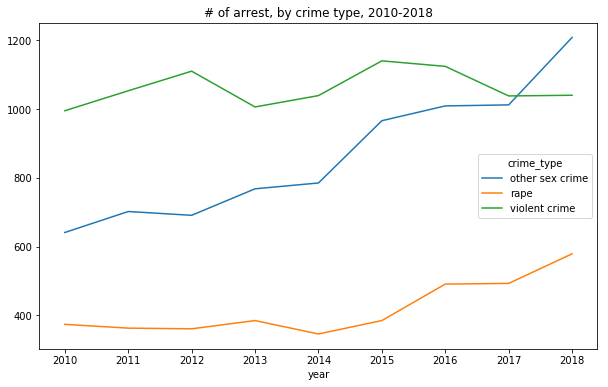

In [111]:

arrest_df = data['is_arrest'] == "yes"


data.groupby('crime_type').year.value_counts().unstack(0).plot.line(
    stacked=False, figsize=(10,6), title="# of arrest, by crime type, 2010-2018")


In [116]:
# Calculate arrest percentages by crime type for each year
arrest_percent_by_yr = pd.crosstab([data.crime_type, data.year],data.is_arrest,
                         normalize = 'index')

# Multiply all percentages by 100 for graphing. 
arrest_percent_by_yr *= 100

# Flatten df
arrest_percent_by_yr.reset_index(inplace=True)

# Remove "no" percentages
arrest_percent_by_yr = arrest_percent_by_yr.drop('no', axis=1)

In [57]:
# Separate data by crime type for visualization

vc_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("violent")]
rape_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("rape")]
other_arr_by_yr = arrest_percent_by_yr[
    arrest_percent_by_yr['crime_type'].str.contains("other")]

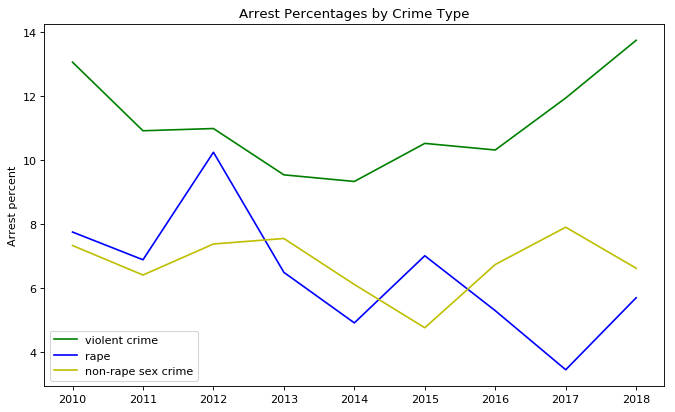

In [92]:
# Plot arrests percentges by year.

plt.figure(figsize=(10,6), dpi= 80)
plt.plot(vc_arr_by_yr.year, vc_arr_by_yr.yes, color='g', label='violent crime')
plt.plot(rape_arr_by_yr.year, rape_arr_by_yr.yes, color='b', label='rape')
plt.plot(other_arr_by_yr.year, other_arr_by_yr.yes, color='y', label='non-rape sex crime')

plt.ylabel('Arrest percent')
plt.title('Arrest Percentages by Crime Type, 2010-2018')
plt.legend()

plt.show()

## 3. TRU Calls


In [65]:
# Create crosstab to view % all TRU calls by crime type

percentage_tru_calls = pd.crosstab(data.final_call_type,data.is_TRU,
                          normalize = 'index').rename_axis(None)
percentage_tru_calls *= 100

is_TRU,no,yes
--ASSAULTS - FIREARM INVOLVED,99.025579,0.974421
--COMMERCIAL SEXUAL EXPLOITATION OF MINORS (CSEC),98.076923,1.923077
--DRIVE BY SHOOTING - NO INJURIES,99.912511,0.087489
--HOMICIDE,100.000000,0.000000
--KIDNAP - GENERAL,98.989899,1.010101
--RAPE - KNOWN SUSPECT (ACQUAINTANCE),97.597204,2.402796
--RAPE - UNKNOWN SUSPECT (STRANGER),98.655914,1.344086
--ROBBERY - ARMED,99.914879,0.085121
--SEX OFFENSES (NON-RAPE) - LEWD CONDUCT,99.076139,0.923861
--SEX OFFENSES (RAPE) - MOLESTING,97.176309,2.823691


Sex crimes where there is a victim, are initially sent to TRU at higher rates than other violent crimes. For the nine years of police calls examined, non-sex-related violent crimes sent to TRU averaged less than 1% of the time. In the same time period, 2.4% of calls reporting acquaintance rape and 2.8% of molestation were sent to TRU.

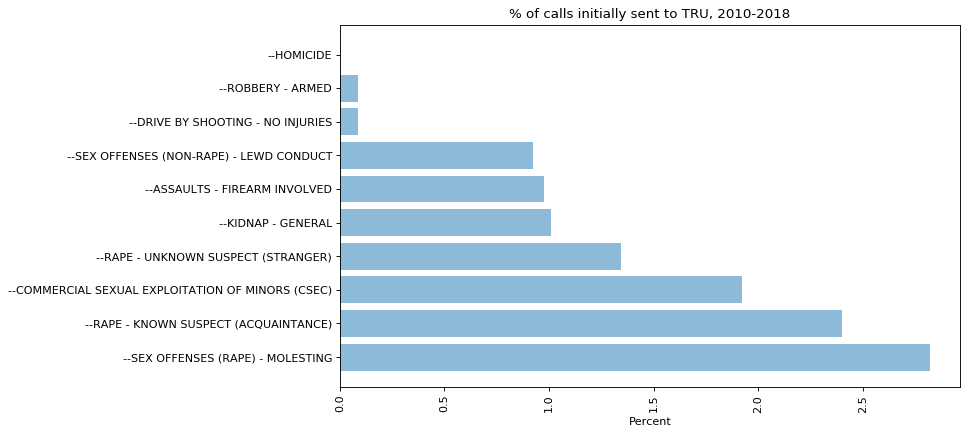

In [82]:
# Plot TRU call percentages as bar graph. 

percentage_tru_sorted = percentage_tru_calls.sort_values('yes',ascending=False)

plt.figure(figsize=(10,6), dpi= 80)
plt.barh(percentage_tru_sorted.index, percentage_tru_sorted.yes, align='center', alpha=0.5)
plt.xlabel('Percent')
plt.title('% of calls initially sent to TRU, 2010-2018')
plt.xticks(rotation=90)

plt.show()

An average of 2.8% of the calls reporting molesting were sent to TRU. 

Even though the overall number of rape calls initially sent to the Telephone Reporting Unit is low, it still means that 75 people called the Seattle Police Department to report a rape and were directed to the same police unit that would handle a call reporting a bicycle that was stolen two years ago.

Between 2010 and 2018, 55 acquaintance rape calls, 20 stranger rape calls and 41 molesting calls were referred to TRU.

**Insert viz showing number of rape and molesting calls sent to TRU**

tutorial: https://pudding.cool/process/flexbox-layout/

In [117]:
# Confirm number of TRU molesting and rape calls

data_tru_df = data[is_tru_mask]
data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("MOLESTING")]
#data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("ACQUAINTANCE")]
#data_tru_df = data_tru_df[data_tru_df.final_call_type.str.contains("STRANGER")]

#data_tru_df.count()

## 4. Lewd Calls

Demonstrate the connections between the amount of time between when the call was taken and when the first officer arrived on scene and the call outcome.

In [102]:
# Create df for all in progress lewd calls with bad arrived_time rows removed
# total i/p lewd calls = 5673
lewd_calls_ip = data[data.arrived_time > '1900-1-1']
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.final_call_type.str.contains("LEWD")]
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.priority <= 3]

In [103]:
# View count of clearing codes
# lewd_calls_ip.event_clearing.value_counts()

In [109]:
# Refine df to only include the 5 most common clearing codes
# 90% of all calls were cleared with one of these clearing calls

top_lewd_cc_terms = 'REPORT WRITTEN|ASSISTANCE RENDERED|PHYSICAL ARREST|UNABLE TO LOCATE|ORAL WARNING'
lewd_calls_ip = lewd_calls_ip[lewd_calls_ip.event_clearing.str.contains(top_lewd_cc_terms)]

### Create Sankey diagram:
* five horizontal flows corresponding to one of ~5-6 time_delta buckets
* final checkpoint goes to how the call was cleared.